In [1]:
import pathlib
import abagen
from IPython.display import display
import pickle
from fooof import FOOOF
import pandas
import scipy
import mat73
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plot_functions import reorganize_roi_gradient, fill, reorder_hemispheres
import data_utils
from abagen import images
import importlib
importlib.reload(data_utils)
importlib.reload(abagen)
from data_utils import nan_sanity_check
import mne
from mne.stats import fdr_correction


In [ ]:
### Loading of the already calculated FOOOF exponents dictionaries ###

with open('fooof_data_HC_1_35.pkl', 'rb') as file:
    fooof_dict_HC = pickle.load(file)

with open('fooof_data_EPI_1_35.pkl', 'rb') as file:
    fooof_dict_EPI = pickle.load(file)

### checking for NaN values deriving from unsuccesful FOOOF calculations ###
nan_sanity_check(fooof_dict_EPI, 'EPI')
nan_sanity_check(fooof_dict_HC, 'HC')

### creating 2 lists from the groups FOOOF dict
list_fooof_epi = [list(value) for value in fooof_dict_EPI.values()]
list_fooof_hc = [list(value) for value in fooof_dict_HC.values()]

In [5]:
donors_info = abagen.fetch_donor_info()  # fetching the abagen donors genes informations
files = abagen.fetch_microarray(donors='all') # downloading the AHBA microarray expression dataset

atlas = abagen.fetch_desikan_killiany() # fetching the Desikan-Killiany cortical atlas parcellations
atlas_info = pd.read_csv(atlas['info'])

donors_list = list(files.keys())

In [6]:

data_dir = pathlib.Path("path\\to\\abagen\\package")

In [7]:
expression_df, report = abagen.get_expression_data(atlas = atlas['image'], atlas_info= atlas['info'], sample_norm = 'srs', gene_norm = 'srs', 
                                                   missing = 'centroids', tolerance = 2, return_report=True, verbose = 1, n_proc=6, data_dir = data_dir)

INFO: Group-level atlas provided; using MNI coords for tissue samples
INFO: Reannotating probes with information from Arnatkevic̆iūtė et al., 2019, NeuroImage
INFO: Filtering probes with intensity-based threshold of 0.5
INFO: 31569 probes survive intensity-based filtering
INFO: Reducing probes indexing same gene with method: diff_stability
INFO: 15633 genes remain after probe filtering + selection
INFO: 782 / 904 samples matched to regions for donor #9861
INFO: 691 / 845 samples matched to regions for donor #10021
INFO: 262 / 353 samples matched to regions for donor #12876
INFO: 405 / 513 samples matched to regions for donor #14380
INFO: 374 / 437 samples matched to regions for donor #15496
INFO: 321 / 414 samples matched to regions for donor #15697
INFO: Matching 2 region(s) with no data to the nearest tissue sample(s)
INFO: Aggregating samples to regions with provided region_agg: donors
INFO: Dropping 0 gene from concatenated expression data due to poor normalization


In [8]:
print(report)

Regional microarry expression data were obtained from 6 post-mortem brains (1 female, ages 24.0--57.0, 42.50 +/- 13.38) provided by the Allen Human Brain Atlas (AHBA, https://human.brain-map.org; [H2012N]). Data were processed with the abagen toolbox (version 0.1.3; https://github.com/rmarkello/abagen) using a 83-region volumetric atlas in MNI space.

First, microarray probes were reannotated using data provided by [A2019N]; probes not matched to a valid Entrez ID were discarded. Next, probes were filtered based on their expression intensity relative to background noise [Q2002N], such that probes with intensity less than the background in >=50.00% of samples across donors were discarded , yielding 31,569 probes . When multiple probes indexed the expression of the same gene, we selected and used the probe with the most consistent pattern of regional variation across donors (i.e., differential stability; [H2015N]), calculated with:

$$ \Delta_{{S}}(p) = \frac{{1}}{{\binom{{N}}{{2}}}} \, 

In [9]:
# Removing from the gene expression dataframe subcortical ROIs (not present in our FOOOF exponents data)
expression_subcortical = [roi['id'] for _,roi in atlas_info.iterrows() if roi['structure'] == 'subcortex/brainstem']
expression_df.drop(expression_df[expression_df.index.isin(expression_subcortical)].index, inplace=True)
display(expression_df)

gene_symbol,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
label,,,,,,,,,,,,,,,,,,,,,
1,0.498266,0.664570,0.395276,0.449984,0.363204,0.390478,0.525830,0.752044,0.339071,0.687745,...,0.536216,0.510445,0.535749,0.470178,0.552097,0.394286,0.664582,0.675843,0.555539,0.487572
2,0.649068,0.578997,0.496142,0.651378,0.374900,0.376148,0.417392,0.670258,0.468810,0.680613,...,0.436584,0.460258,0.394620,0.439953,0.380107,0.495299,0.632483,0.483165,0.382653,0.504041
3,0.530613,0.623289,0.516300,0.387376,0.438570,0.548449,0.511302,0.785473,0.352448,0.571331,...,0.498757,0.624526,0.478582,0.350420,0.377683,0.361561,0.678239,0.732930,0.359707,0.450664
4,0.357235,0.577027,0.472538,0.407110,0.351562,0.439605,0.652987,0.752140,0.443812,0.564911,...,0.574279,0.579238,0.440776,0.394898,0.427183,0.380926,0.651013,0.845008,0.564132,0.371442
5,0.668703,0.533731,0.595773,0.524926,0.412263,0.446762,0.340154,0.699326,0.478007,0.617597,...,0.452369,0.543893,0.715963,0.371176,0.383864,0.502091,0.715354,0.328519,0.388377,0.557719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.405751,0.638777,0.337236,0.531219,0.526678,0.374615,0.473261,0.833944,0.323568,0.707159,...,0.650324,0.548665,0.507043,0.422434,0.546888,0.383177,0.804409,0.672717,0.541597,0.346724
72,0.574699,0.750184,0.246746,0.304452,0.249238,0.305679,0.371769,0.806277,0.467807,0.560997,...,0.477924,0.751611,0.608376,0.459216,0.368311,0.276562,0.703707,0.656938,0.193677,0.647785
73,0.725151,0.652906,0.528831,0.411260,0.402389,0.445176,0.565688,0.854264,0.448293,0.747667,...,0.631322,0.534723,0.654596,0.306574,0.515961,0.613370,0.722551,0.478334,0.501293,0.483642


**PCA delle prime 10 componenti e scelte delle 3 più esplicative**

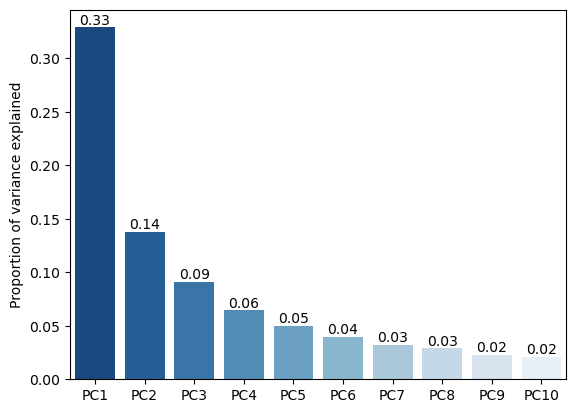

In [10]:
from sklearn.decomposition import PCA

# Performing a PCA of the first 10 components of the gene expression
pca = PCA(n_components = 10)

principal_components = pca.fit_transform(expression_df)

zscore_pcs = scipy.stats.zscore(principal_components ,axis=1)
explained_variance_ratio = pca.explained_variance_ratio_

# creating a dataframe [n_rois x n_components] of the PCs values
principal_df = pd.DataFrame(data=zscore_pcs, columns=[f'PC{i+1}' for i in range(len(explained_variance_ratio))])

# pca.components_ give us the weight of the original features on the resulting principal components:
pcs_weights = pca.components_
df_pc_weights = pd.DataFrame(pca.components_.T[:,:5], index=expression_df.columns, columns=['pc%i'%i for i in range(1, 6)])


# plot of the explained variance of the first 10 principal components
palette = sns.color_palette('Blues_r', len(explained_variance_ratio))
ax = sns.barplot(x = [f'PC{i}' for i in np.arange(1,len(explained_variance_ratio)+1)], y = explained_variance_ratio, palette=palette)
ax.bar_label(ax.containers[0], fontsize=10, fmt = "%.2f")
plt.ylabel('Principal components')
plt.ylabel('Proportion of variance explained')
plt.show()

In [11]:
### top 20 genes eigenvalues for the first 3 PCA components ###

top_20_pc1 = df_pc_weights.iloc[:,0].abs().nlargest(20)
top_20_pc2 = df_pc_weights.iloc[:,1].abs().nlargest(20)
top_20_pc3 = df_pc_weights.iloc[:,2].abs().nlargest(20)

df = pd.DataFrame({'PC1': list(zip(top_20_pc1.keys(), round(top_20_pc1,4))), 'PC2': list(zip(top_20_pc2.keys(), round(top_20_pc2,4))), 'PC3': list(zip(top_20_pc3.keys(), round(top_20_pc3,4)))})
print(df.to_markdown(index=False))

| PC1                       | PC2                  | PC3                   |
|:--------------------------|:---------------------|:----------------------|
| ('SLA', 0.0302)           | ('FREM3', 0.0288)    | ('ESM1', 0.0331)      |
| ('SCN1B', 0.0296)         | ('TPBG', 0.0288)     | ('XIRP1', 0.0312)     |
| ('PRSS35', 0.0295)        | ('LCP2', 0.0263)     | ('MYMX', 0.0253)      |
| ('PEA15', 0.0295)         | ('TTR', 0.0253)      | ('GTF2IP20', 0.0249)  |
| ('LAG3', 0.0286)          | ('TP53TG3D', 0.0248) | ('DLK1', 0.0249)      |
| ('PTGER3', 0.0284)        | ('ASGR2', 0.0248)    | ('LINC00302', 0.0248) |
| ('LRRC3B', 0.0281)        | ('MEDAG', 0.0239)    | ('DUS1L', 0.0248)     |
| ('DKFZp779M0652', 0.0279) | ('SMIM12', 0.0237)   | ('KIF13B', 0.0248)    |
| ('SCN1A', 0.027)          | ('LUZP1', 0.0235)    | ('PBDC1', 0.0245)     |
| ('PYDC1', 0.0269)         | ('AMDHD1', 0.0231)   | ('EID2B', 0.0245)     |
| ('PKIA', 0.0269)          | ('PEF1', 0.0227)     | ('ZNF585B', 0.0244)   |

In [12]:
epi_fooof_df = pd.DataFrame(np.array(list_fooof_epi).T)
hc_fooof_df = pd.DataFrame(np.array(list_fooof_hc).T)

average_fooof_hc = reorganize_roi_gradient(reorder_hemispheres(hc_fooof_df.mean(axis=1).values))
average_fooof_epi = reorganize_roi_gradient(reorder_hemispheres(epi_fooof_df.mean(axis=1).values))

print('Correlation calculated using PCA algorithm \n' '------------------------------------------')
corr_epi, p_val_epi = scipy.stats.spearmanr(average_fooof_epi, principal_df['PC1'].values)
corr_hc, p_val_hc = scipy.stats.spearmanr(average_fooof_hc, principal_df['PC1'].values)
print(f'The correlation between the first Principal Component and the Roi-wise average FOOOF in Epi group is {round(corr_epi,4)} and p_value {round(p_val_epi,4)}\n' 
      f'The correlation between the first Principal Component and the Roi-wise average FOOOF in HC group is {round(corr_hc,4)} and p_value {round(p_val_hc,4)}\n'
      f'--------------------------------------------------------------------------------------------------------------------------------')

corr_epi, p_val_epi = scipy.stats.spearmanr(average_fooof_epi, principal_df['PC2'].values)
corr_hc, p_val_hc = scipy.stats.spearmanr(average_fooof_hc, principal_df['PC2'].values)
print(f'The correlation between the second Principal Component and the Roi-wise average FOOOF in Epi group is {round(corr_epi,4)} and p_value {round(p_val_epi,4)}\n' 
      f'The correlation between the second Principal Component and the Roi-wise average FOOOF in HC group is {round(corr_hc,4)} and p_value {round(p_val_hc,4)}\n'
      f'--------------------------------------------------------------------------------------------------------------------------------')

corr_epi, p_val_epi = scipy.stats.spearmanr(average_fooof_epi, principal_df['PC3'].values)
corr_hc, p_val_hc = scipy.stats.spearmanr(average_fooof_hc, principal_df['PC3'].values)
print(f'The correlation between the third Principal Component and the Roi-wise average FOOOF in Epi group is {round(corr_epi,4)} and p_value {round(p_val_epi,4)}\n' 
      f'The correlation between the third Principal Component and the Roi-wise average FOOOF in HC group is {round(corr_hc,4)} and p_value {round(p_val_hc,4)}\n'
      f'--------------------------------------------------------------------------------------------------------------------------------')

Correlation calculated using PCA algorithm 
------------------------------------------
The correlation between the first Principal Component and the Roi-wise average FOOOF in Epi group is -0.2485 and p_value 0.041
The correlation between the first Principal Component and the Roi-wise average FOOOF in HC group is 0.1123 and p_value 0.3617
--------------------------------------------------------------------------------------------------------------------------------
The correlation between the second Principal Component and the Roi-wise average FOOOF in Epi group is 0.4163 and p_value 0.0004
The correlation between the second Principal Component and the Roi-wise average FOOOF in HC group is 0.0214 and p_value 0.8626
--------------------------------------------------------------------------------------------------------------------------------
The correlation between the third Principal Component and the Roi-wise average FOOOF in Epi group is 0.0045 and p_value 0.9709
The correlation betw

In [13]:
### creating dataframes for the FOOOF exponents values ###
epi_fooof_df = pd.DataFrame(np.array(list_fooof_epi).T)
hc_fooof_df = pd.DataFrame(np.array(list_fooof_hc).T)

### reorganizing data to match abagen desikan-killiany atlas parcels order and averaging along observations (EPI=67, HC=35) axes ###
average_fooof_hc = reorganize_roi_gradient(reorder_hemispheres(hc_fooof_df.mean(axis=1).values)) 
average_fooof_epi = reorganize_roi_gradient(reorder_hemispheres(epi_fooof_df.mean(axis=1).values)) 

### importing names of epilepsy related genes from an external file and checking if they are present in abagen dataset ###
epi_genes_df = pd.read_excel('data\selected_epi_genes.xlsx')
epi_genes_list = epi_genes_df['Genes of interest'].tolist()
epi_genes = [gene for gene in epi_genes_list if gene in expression_df.columns]

In [14]:
print(f'The chosen genes are {len(epi_genes)}: \n')
print(np.array(epi_genes))

The chosen genes are 22: 

['LGI1' 'CNTNAP2' 'GRIN2A' 'SCN1A' 'SCN1B' 'SCN2A' 'KCNA2' 'KCNB1' 'KCNC1'
 'KCNMA1' 'KCNQ3' 'KCNT1' 'GABRA1' 'GABRB1' 'GABRB2' 'GABRB3' 'GABRD'
 'GABRG2' 'GRIN2B' 'GRIN2D' 'GRINA' 'PDYN']


#### **Plot of the ROI-wise linear regression between FOOOF exponent values and genes expression and Spearman rho calculation**

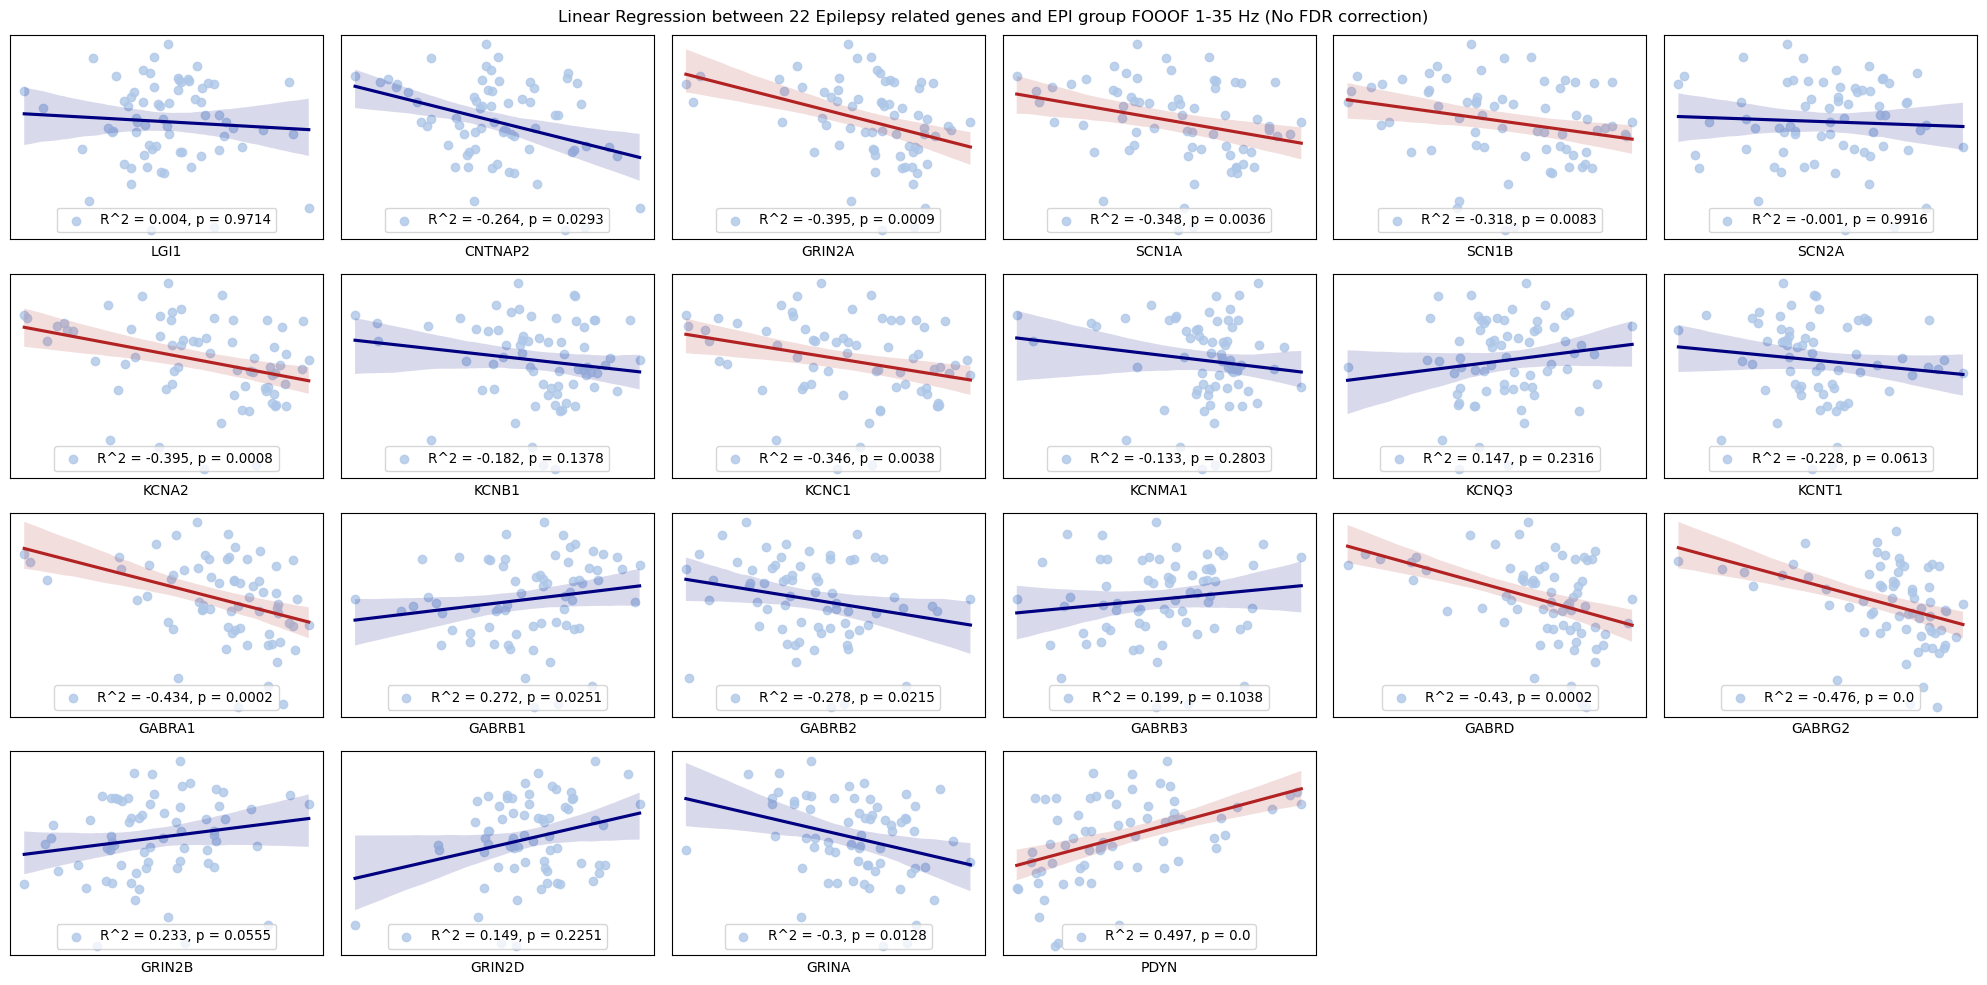

In [15]:
y = average_fooof_epi
xs = [expression_df[i] for i in epi_genes]

#spearman_correlations = [scipy.stats.spearmanr(xs[i], y).correlation for i in range(np.shape(xs)[0])]

# Set up a 4 by 6 grid of subplots and calculate the linear regression between each gene of interest and average EPI group FOOOF
fig, axes = plt.subplots(4, 6, figsize=(20, 10))
axes = axes.flatten()

r_2_epi, rho_epi, p_val_epi, p_val_rho_epi= [], [], [], []

for i, ax in enumerate(axes):
    if i < len(epi_genes):
        rho, p_rho = scipy.stats.spearmanr(xs[i], y)
        m,b,r,p,_ = scipy.stats.linregress(xs[i], y)
        if p_rho <= 0.01:
            color = 'firebrick'
        else:
            color = 'navy'
        sns.regplot(x = xs[i], y = y, ax = ax, x_ci= None, color='#AEC7E8' , label = f'R^2 = {round(rho,3)}, p = {round(p_rho, 4)}', line_kws = {'color':color});
        ax.tick_params(left = False, right = False , labelleft = False , 
                        labelbottom = False, bottom = False) 
        r_2_epi.append(r)
        rho_epi.append(rho)
        p_val_epi.append(p)
        p_val_rho_epi.append(p_rho)
        ax.set_xlabel(f'{epi_genes[i]}')
        ax.legend(fontsize=9.7, loc = 'lower center')
    else:
        break

for j in range(len(epi_genes), len(axes)):
    axes[j].axis('off')

plt.suptitle('Linear Regression between 22 Epilepsy related genes and EPI group FOOOF 1-35 Hz (No FDR correction)')
plt.tight_layout()


In [70]:

reject_epi, pval_corr_epi = fdr_correction(p_val_rho_epi, alpha=0.01, method="indep")
#rho_epi_corrected = reject_epi*rho_epi
#pval_corr_epi = reject_epi*pval_corr_epi
idx_significant_genes = [idx for idx, boolean in enumerate(reject_epi) if boolean == True] 
significat_genes_labels = [epi_genes[idx] for idx in idx_significant_genes]
print(f'The genes that are still significant after FDR correction (along number of genes, alpha = 0.01) are: {significat_genes_labels}')

The genes that are still significant after FDR correction (along number of genes, alpha = 0.01) are: ['GRIN2A', 'KCNA2', 'GABRA1', 'GABRD', 'GABRG2', 'PDYN']


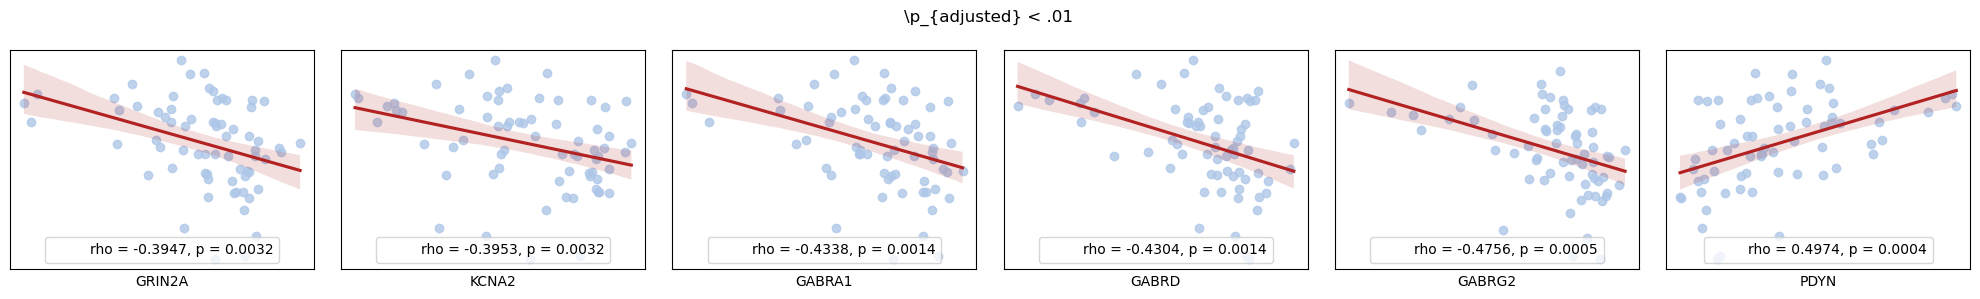

In [71]:
#epi_genes = 'LGI1' 'CNTNAP2' 'GRIN2A' 'SCN1A' 'SCN1B' 'SCN2A' 'KCNA2' 'KCNB1' 'KCNC1' 'KCNMA1' 'KCNQ3' 'KCNT1' 'GABRA1' 'GABRB1' 'GABRB2' 'GABRB3' 'GABRD' 'GABRG2' 'GRIN2B' 'GRIN2D' 'GRINA' 'PDYN'
import matplotlib.patches as mpatches

rho_epi_corrected = [rho_epi for rho_epi in reject_epi*rho_epi if rho_epi!=0]
pval_corr_epi = [pval for pval in reject_epi*pval_corr_epi if pval!=0]
idx_significant_genes = [idx for idx, boolean in enumerate(reject_epi) if boolean == True] 
significat_genes_labels = [epi_genes[idx] for idx in idx_significant_genes]

y = average_fooof_epi
xs = [expression_df[i] for i in significat_genes_labels]

# Set up a 4 by 6 grid of subplots and calculate the linear regression between each gene of interest and average EPI group FOOOF
fig, axes = plt.subplots(1, len(xs), figsize=(20,3))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(significat_genes_labels):
        m,b,r,p,_ = scipy.stats.linregress(xs[i], y)

        sns.regplot(x = xs[i], y = y, ax = ax, x_ci= None, color='#AEC7E8', line_kws = {'color':'firebrick'});
        empty_patch = mpatches.Patch(color='none', label = f'rho = {round(rho_epi_corrected[i],4)}, p = {round(pval_corr_epi[i], 4)}') 
        ax.legend(handles=[empty_patch], fontsize=10, loc = 'lower center')
        ax.tick_params(left = False, right = False , labelleft = False , 
                        labelbottom = False, bottom = False) 
        ax.set_xlabel(f'{significat_genes_labels[i]}')
        #ax.legend(fontsize=9.7, loc = 'lower center')
    else:
        break

for j in range(len(significat_genes_labels), len(axes)):
    axes[j].axis('off')

#plt.suptitle(f'Linear Regression between 22 Epilepsy related genes and EPI group FOOOF 1-35 Hz no correction')

plt.suptitle('$p_{adjusted}$ < .01$')
plt.tight_layout()


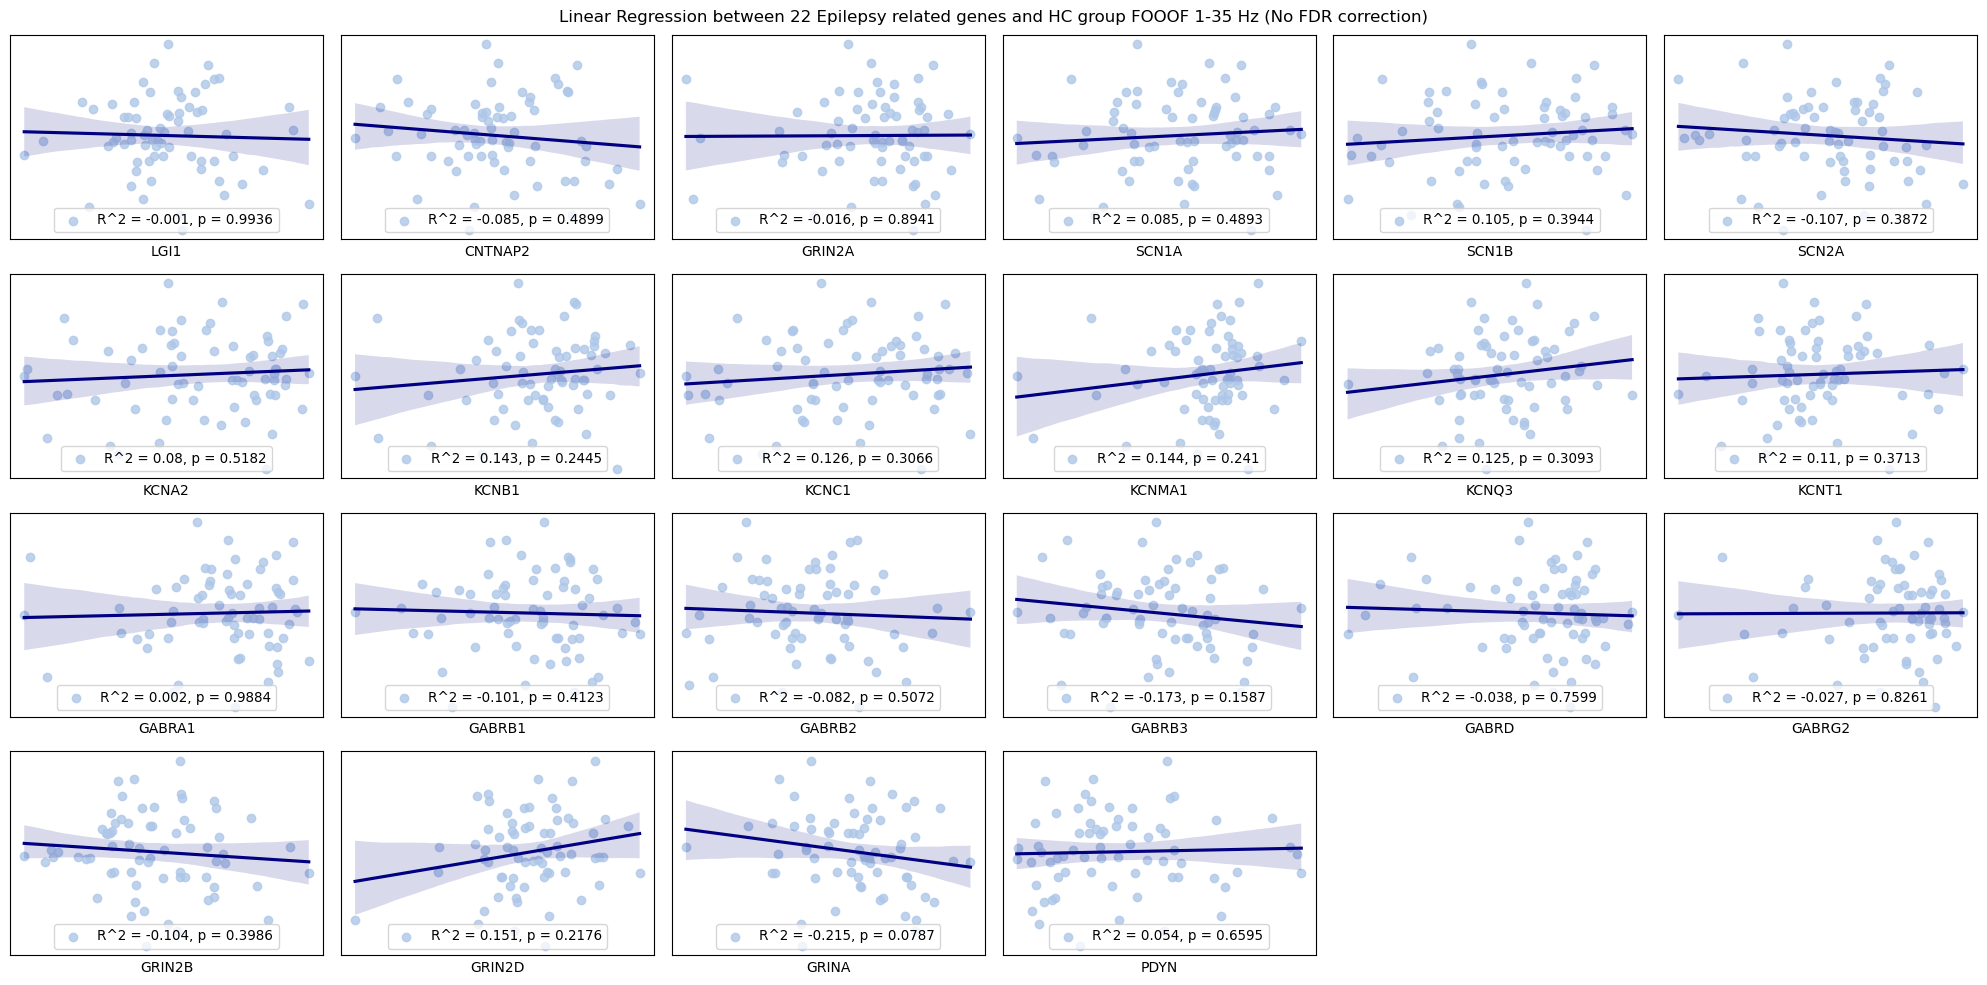

In [65]:
y = average_fooof_hc
xs = [expression_df[i] for i in epi_genes]

p_vals_epi = []

# Set up a 4 by 4 grid of subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))
axes = axes.flatten()

r_2_hc, rho_hc, p_val_hc, p_val_rho_hc = [], [], [], []

for i, ax in enumerate(axes):
    if i < len(epi_genes):
        rho, p_rho = scipy.stats.spearmanr(xs[i], y)
        m,b,r,p,_ = scipy.stats.linregress(xs[i], y)
        if p_rho <= 0.01:
            color = 'firebrick'
        else:
            color = 'navy'
        sns.regplot(x = xs[i], y = y, ax = ax, x_ci= None, color='#AEC7E8' , label = f'R^2 = {round(rho,3)}, p = {round(p_rho, 4)}', line_kws = {'color':color});
        ax.tick_params(left = False, right = False , labelleft = False , 
                        labelbottom = False, bottom = False) 
        r_2_hc.append(r)
        p_val_hc.append(p)
        rho_hc.append(rho)
        p_val_rho_hc.append(p_rho)
        ax.set_xlabel(f'{epi_genes[i]}')
        ax.legend(fontsize=9.7, loc = 'lower center')
    else:
        break

for j in range(len(epi_genes), len(axes)):
    axes[j].axis('off')

plt.suptitle('Linear Regression between 22 Epilepsy related genes and HC group FOOOF 1-35 Hz (No FDR correction)')
plt.tight_layout()

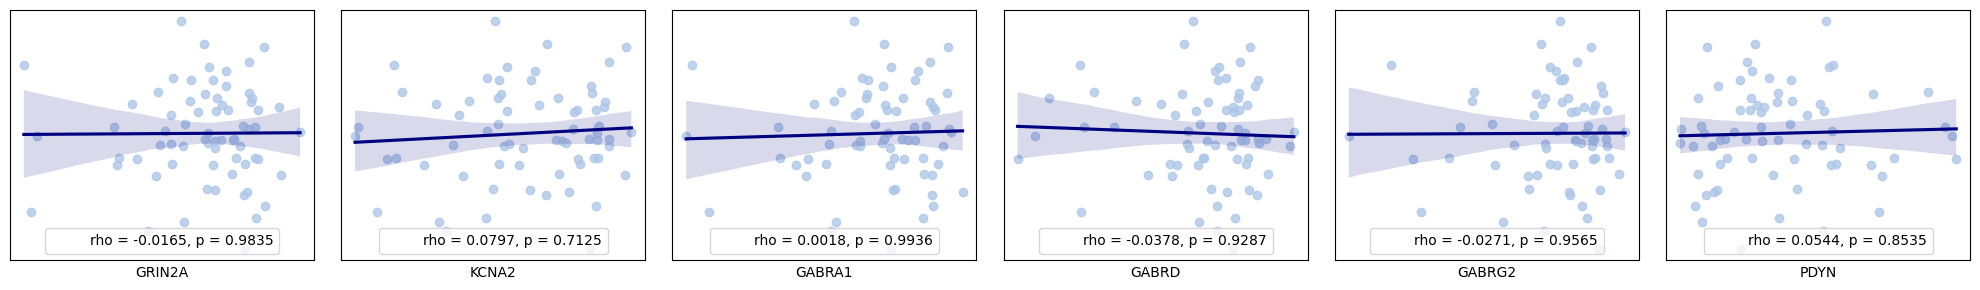

In [66]:
_, pval_corr_hc = fdr_correction(p_val_rho_hc, alpha=0.01, method="indep")

rho_hc_corrected = [rho_hc[i] for i in range(len(rho_hc)) if i in idx_significant_genes] 
pval_corr_hc = [pval_corr_hc[i] for i in range(len(pval_corr_hc)) if i in idx_significant_genes]

significant_genes_labels = [epi_genes[idx] for idx in idx_significant_genes]

y = average_fooof_hc
xs = [expression_df[i] for i in significant_genes_labels]

# Set up a 4 by 6 grid of subplots and calculate the linear regression between each gene of interest and average EPI group FOOOF
fig, axes = plt.subplots(1, len(xs), figsize=(20,3))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(significant_genes_labels):
        m,b,r,p,_ = scipy.stats.linregress(xs[i], y)

        sns.regplot(x = xs[i], y = y, ax = ax, x_ci= None, color='#AEC7E8', line_kws = {'color':'navy'});
        empty_patch = mpatches.Patch(color='none', label = f'rho = {round(rho_hc_corrected[i],4)}, p = {round(pval_corr_hc[i], 4)}') 
        ax.legend(handles=[empty_patch], fontsize=10, loc = 'lower center')
        ax.tick_params(left = False, right = False , labelleft = False , 
                        labelbottom = False, bottom = False) 
        ax.set_xlabel(f'{significant_genes_labels[i]}')
        #ax.legend(fontsize=9.7, loc = 'lower center')
    else:
        break

for j in range(len(significant_genes_labels), len(axes)):
    axes[j].axis('off')

#plt.suptitle(f'Linear Regression between 22 Epilepsy related genes and EPI group FOOOF 1-35 Hz no correction')
plt.tight_layout()